# Train the GAN

In [2]:
import tensorflow as tf
tf.__version__
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import os
from tensorflow.keras import layers
import time

from IPython import display

## Load Dataset

2023-10-03 17:05:12.748249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-10-03 17:05:12.748270: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (himalaya-fon): /proc/driver/nvidia/version does not exist
2023-10-03 17:05:12.754595: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2820, 40, 120, 1)


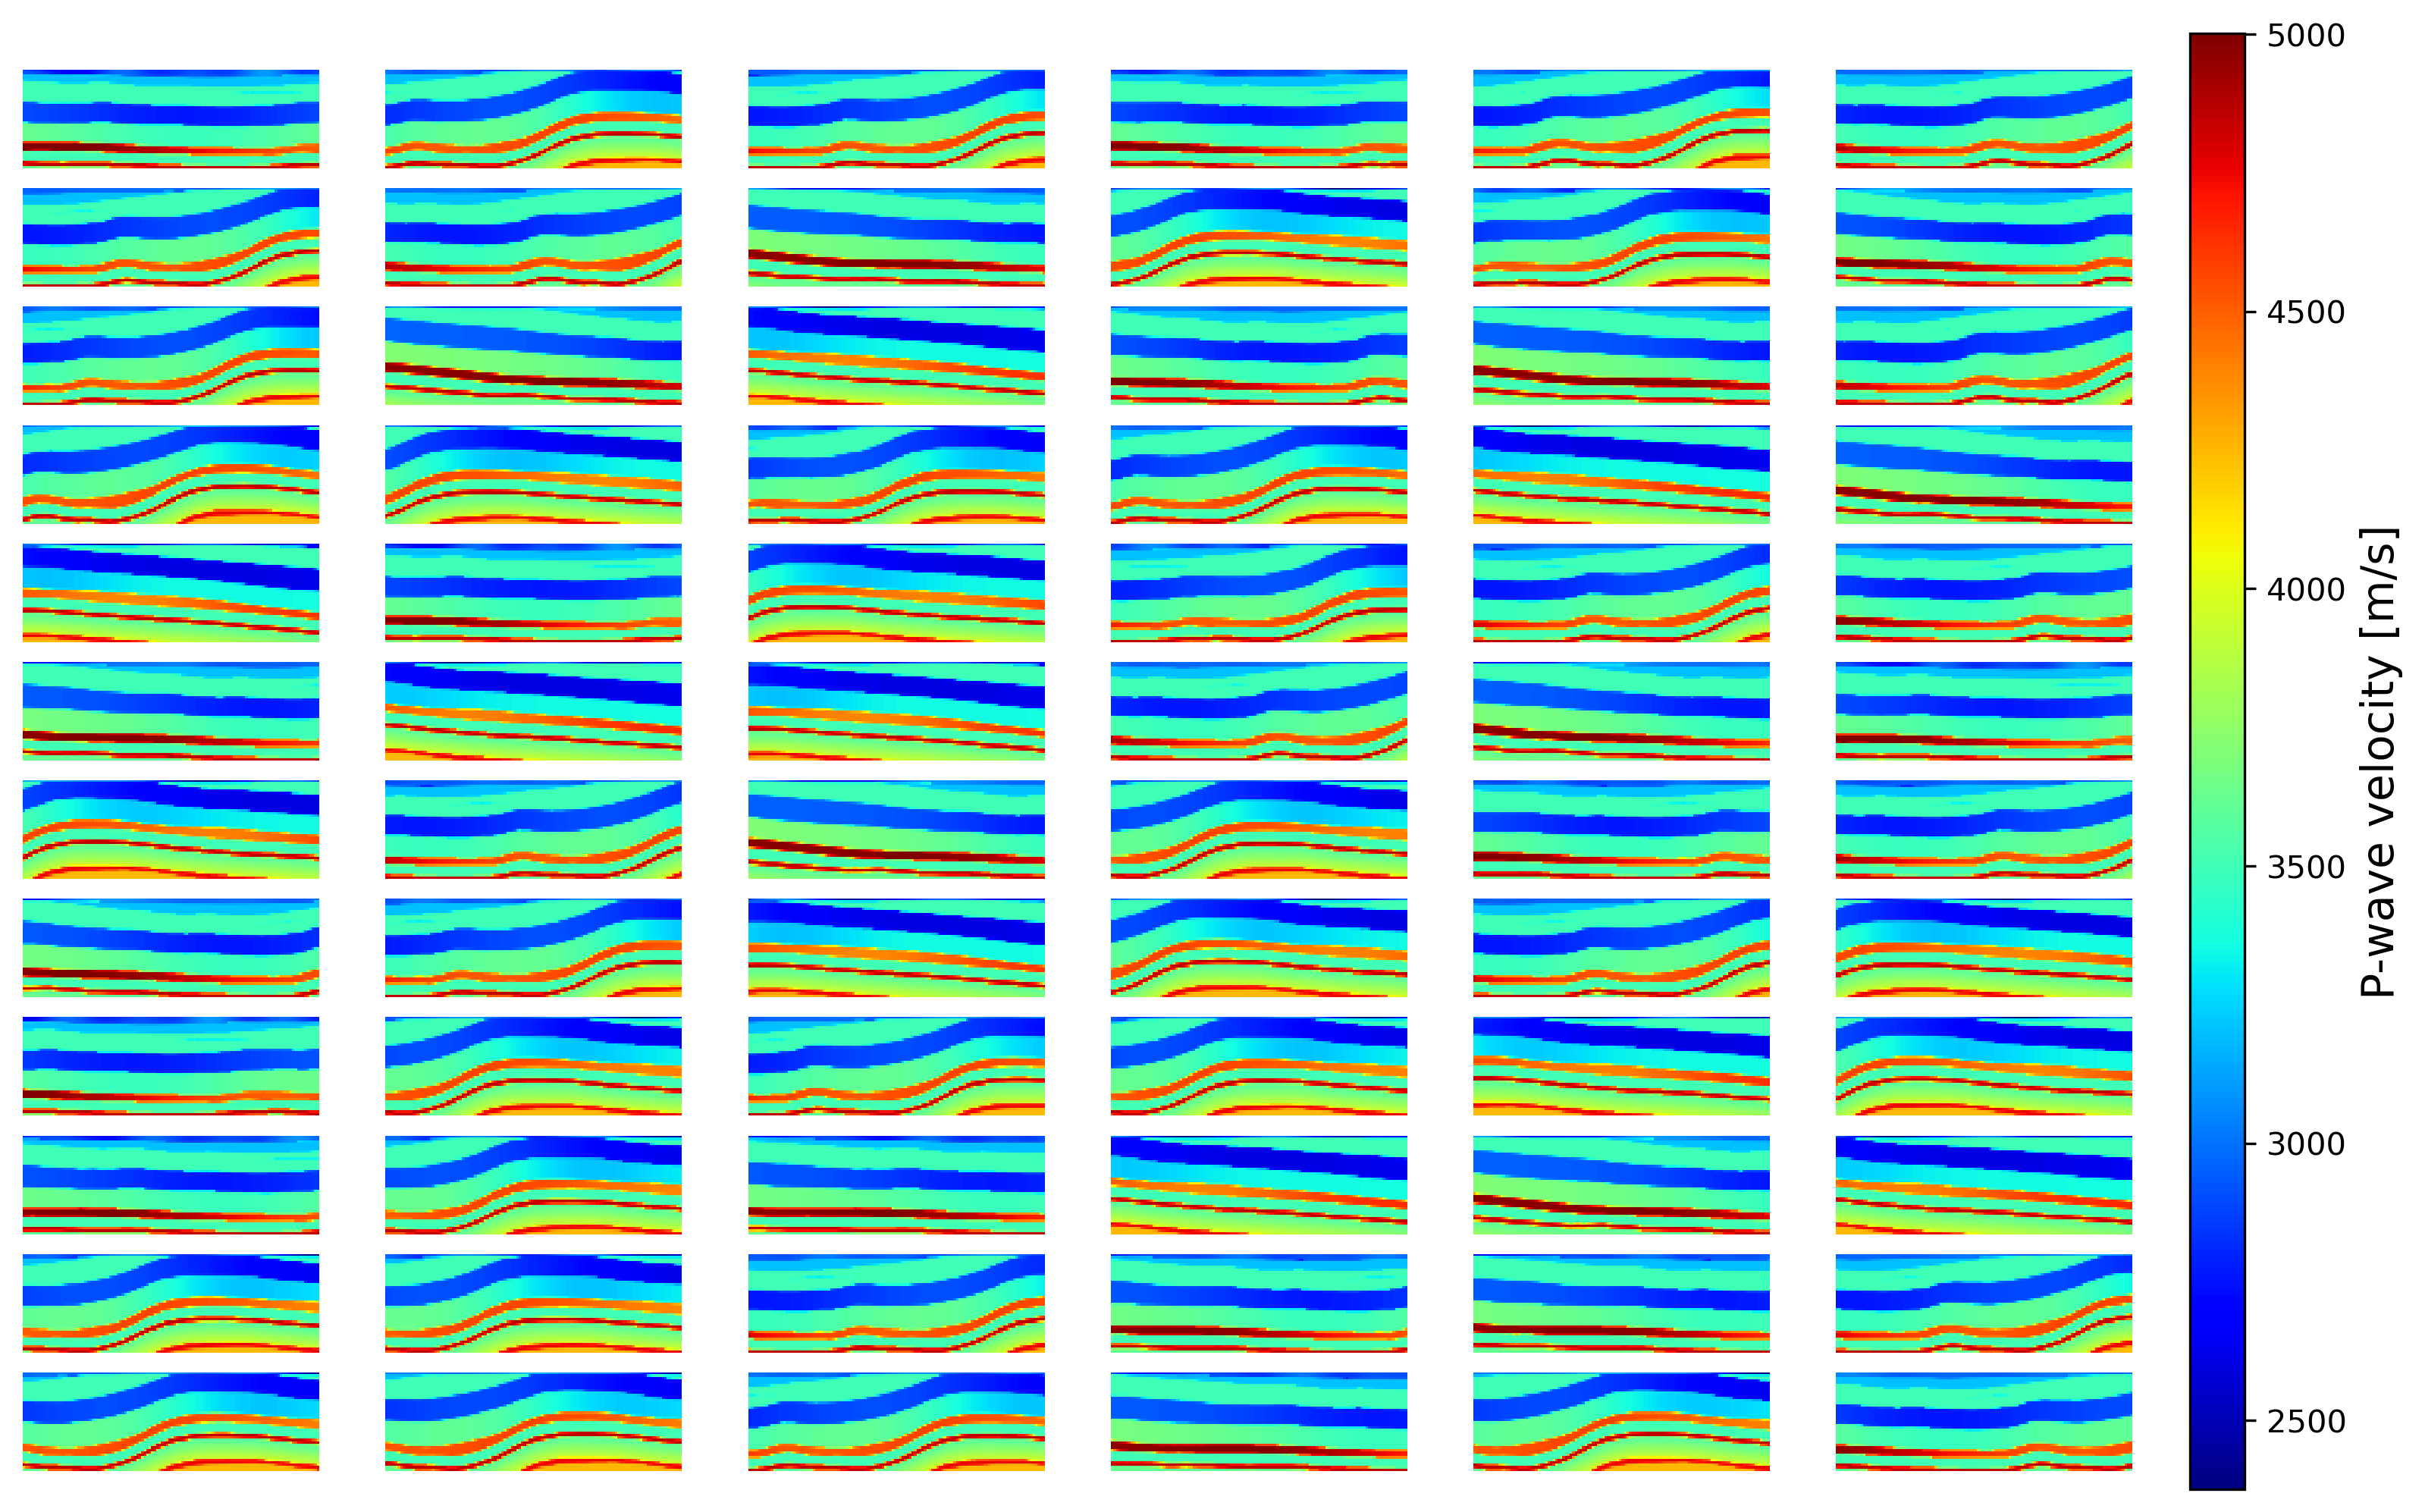

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

# n1= 93 n2=401 n3=401 d1=d2=d3=50m
vel = readbin('../dataset/overthrust.bin',93,401*401)
# vel = np.round(vel / 100) * 100 # Quantize image (Smaller image depth)
vel = np.reshape(vel,[93,401,401])
n = 120
vel = vel[:41, :, 60:70]
vmin, vmax = vel.min(), vel.max()

def crop_images(data, crop_size, z_interval, x_interval, y_interval):
    cropped_images = []
    nz, nx, ny = data.shape

    for y in range(0, ny, y_interval):
        for z in range(0, nz - crop_size[0], z_interval):
          for x in range(0, nx - crop_size[1] + 1, x_interval):
              cropped_images.append(data[z:z+crop_size[0], x:x+crop_size[1], y])

    return np.array(cropped_images)

# Given data (replace this with your actual data)
crop_size = (40, 120)  # Crop size [height, width]
z_interval = crop_size[0]//8  # Interval on z-axis
x_interval = crop_size[1]//8 # Interval on x-axis
y_interval = crop_size[1]//8  # Interval on y-axis

z_interval = 1  # Interval on z-axis
x_interval = 1 # Interval on x-axis
y_interval = 1  # Interval on y-axis

# Crop images
cropped_images = crop_images(vel, crop_size, z_interval, x_interval, y_interval)
n_img = cropped_images.shape[0]
cropped_images = cropped_images.reshape(n_img, crop_size[0], crop_size[1], 1).astype('float32')

# Upsample the images to the target size
# cropped_images = tf.image.resize(cropped_images, size=(200, 600))
cropped_images = tf.cast(cropped_images, tf.float32)

# Display shape of cropped images
print(cropped_images.shape)

fig = plt.figure(figsize=(12, 8), dpi=300)
for i in range(72):
  plt.subplot(12, 6, i+1)
  plt.imshow(cropped_images[np.random.randint(cropped_images.shape[0]),:,:],cmap='jet',vmin=vmin,vmax=vmax)
  # plt.imshow(cropped_images[i,:,:],cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
# Show the plot
plt.show()


## Normalize images

In [7]:
train_images = cropped_images.numpy()
# train_images = train_images.reshape(train_images.shape[0], 201, 601, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
z1,x1 = train_images.shape[1],train_images.shape[2]
vmin, vmax = np.min(train_images),np.max(train_images)

def my_norm(a, min_val, max_val):
    ratio = 2/(max_val - min_val)
    shift = (max_val+min_val)/2
    return (a - shift)*ratio

def inverse_norm(a, min_val, max_val):
    ratio = 2 / (max_val - min_val)
    shift = (max_val + min_val) / 2
    return (a / ratio) + shift

train_images = my_norm(train_images,vmin,vmax)
print(train_images.min(),train_images.max())

BUFFER_SIZE = n_img
BATCH_SIZE = 64
dim_z=100
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

-0.99999994 0.99999994


## Define Generator and Discriminator

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

kernal_size = (5, 5)

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(z1*x1//16*256, use_bias=False, input_shape=(dim_z,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((z1//4, x1//4, 256)))
    assert model.output_shape == (None, z1//4, x1//4, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, kernal_size, strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//4, x1//4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, kernal_size, strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, z1//2, x1//2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, kernal_size, strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, z1, x1, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, kernal_size, strides=(2, 2), padding='same',
                                     input_shape=[z1, x1, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, kernal_size, strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return [gen_loss, disc_loss]

def train(dataset, epochs, loss_history = []):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      loss = train_step(image_batch)
    loss_history.append(loss)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed,
                             loss_history)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed,
                           loss_history)
  return loss_history

def generate_and_save_images(model, epoch, test_input, loss_history):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  Gz = model(test_input, training=False)

  fig = plt.figure(figsize=(12, 4),dpi=300)
  plt.suptitle(f"Epoch {epoch}")
  for i in range(num_examples_to_generate):
    plt.subplot(4, 4, i+1)
    Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
    plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
    plt.axis('off')

  # Add a single colorbar for all subplots
  cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
  cbar = plt.colorbar(cax=cax)
  cbar.formatter.set_useMathText(True)
  cbar.formatter.set_scientific(True)
  cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
  cbar.update_ticks()
  cbar.set_label("P-wave velocity [m/s]", fontsize=14)
  # Show the plot
  # plt.savefig('./dcgan/img/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


  fig = plt.figure(figsize=(8, 4),dpi=100)
  plt.plot(loss_history)
  plt.legend(['Generator loss', 'Discriminator loss'])
  plt.show()

## Train the model

tf.Tensor([[-0.00073833]], shape=(1, 1), dtype=float32)


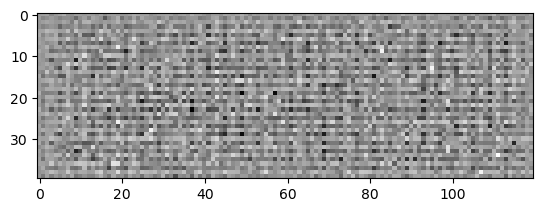

In [9]:
generator = make_generator_model()
noise = tf.random.normal([1, dim_z])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

checkpoint_dir = './dcgan/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

EPOCHS = 50000
noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

global loss_history
restore = 1
training = 0
if restore==1: 
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
else:  loss_history = []
if training==1: train(train_dataset, EPOCHS)

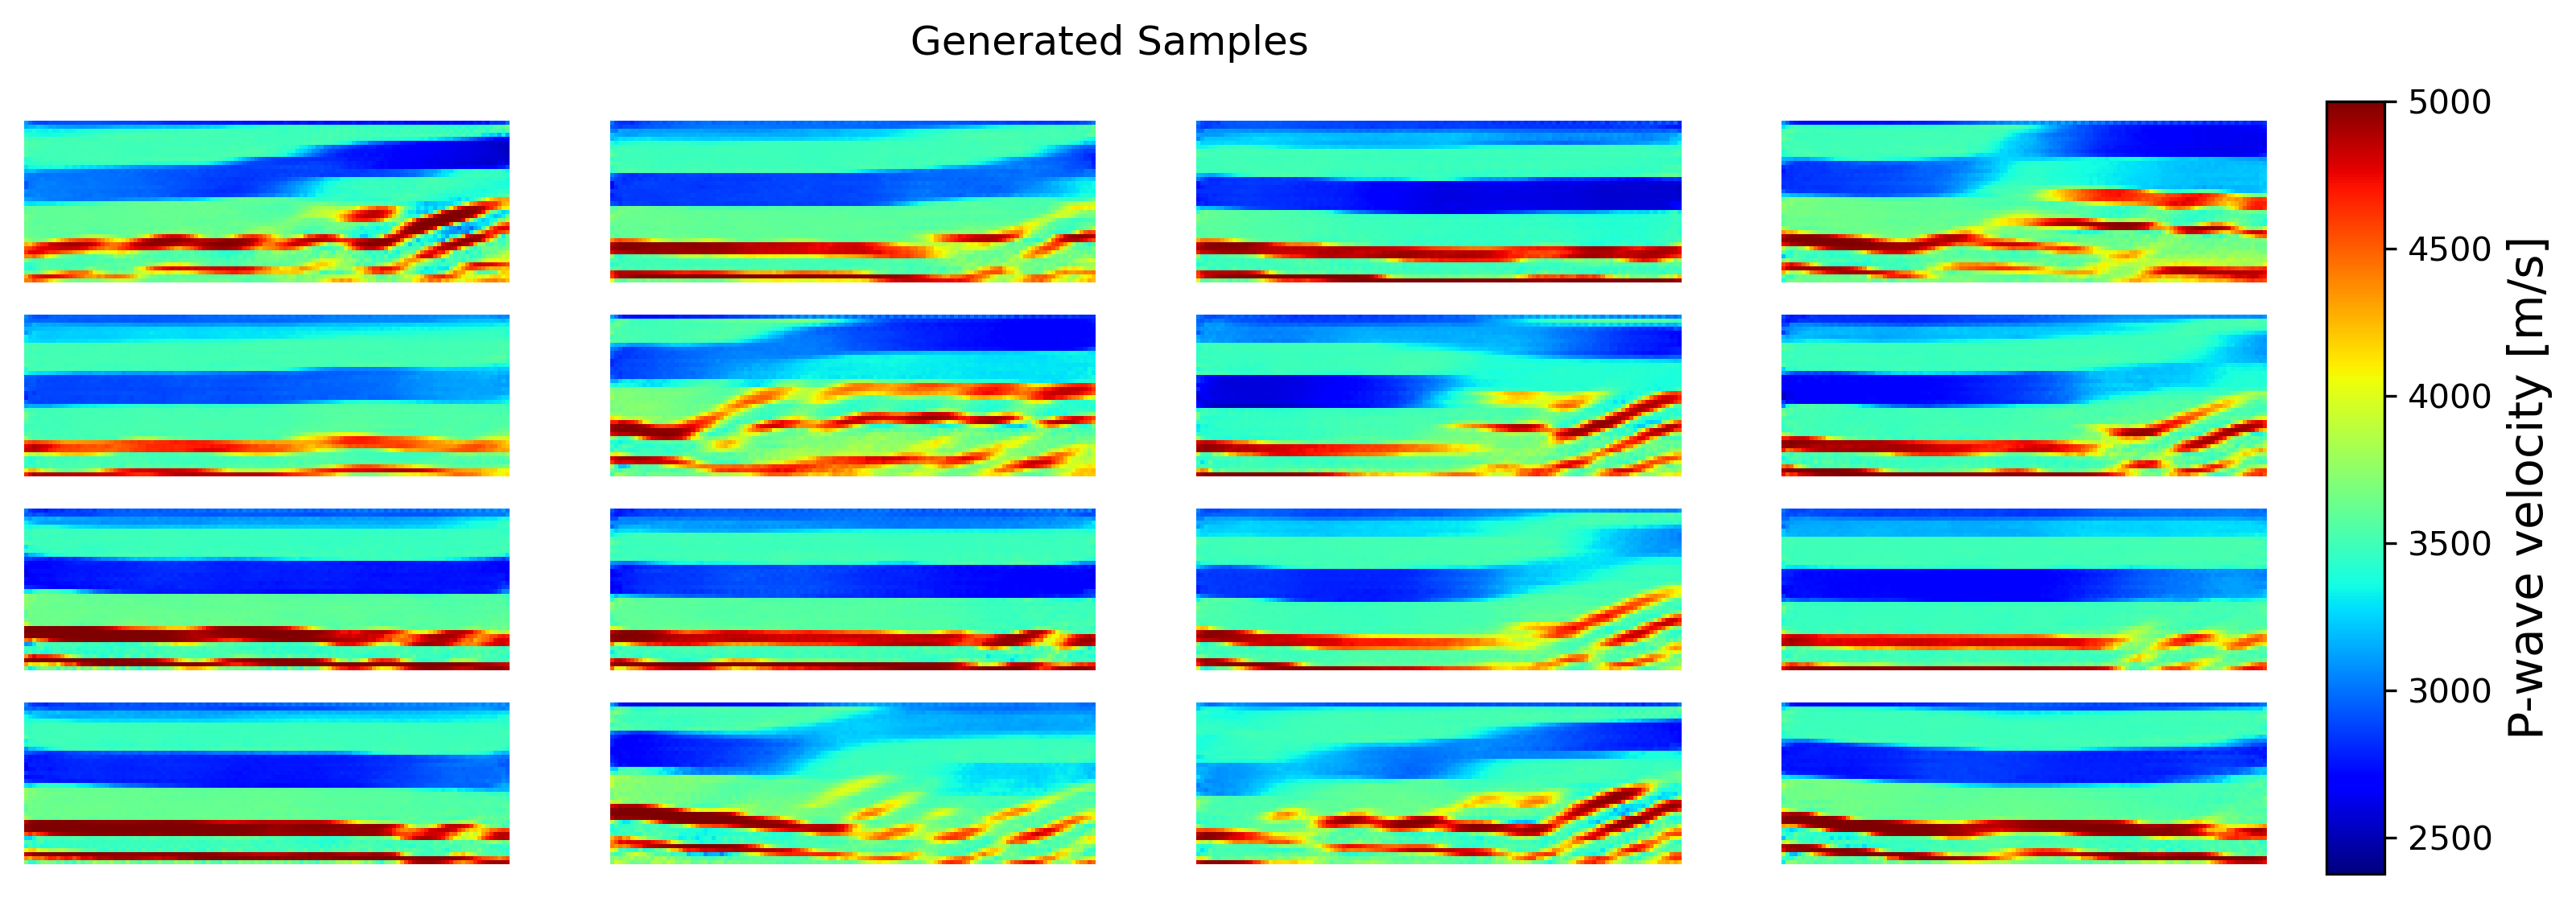

In [16]:
import tensorflow as tf
import numpy as np

def gaussian_kernel(kernel_size, sigma=1.0):
    x = np.linspace(-sigma, sigma, kernel_size)
    kernel = np.exp(-(x**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel.astype(np.float32)

def apply_gaussian_smoothing(images, kernel_size=5, sigma=1.0):
    # Create a Gaussian kernel
    kernel = gaussian_kernel(kernel_size, sigma)
    kernel = kernel[:, np.newaxis] * kernel[np.newaxis, :]

    # Apply 2D convolution with the Gaussian kernel
    smoothed_images = tf.nn.conv2d(images, kernel[..., np.newaxis, np.newaxis], strides=[1, 1, 1, 1], padding="SAME")

    return smoothed_images

# Example usage
# Assuming `generated_images` contains your DCGAN-generated grayscale images
# smoothed_images = apply_gaussian_smoothing(Gz, kernel_size=5, sigma=5)

noise_dim = dim_z
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])
Gz = generator(seed, training=False)
# Gz = apply_gaussian_smoothing(Gz)
fig = plt.figure(figsize=(12, 4),dpi=300)
plt.suptitle("Generated Samples")
for i in range(num_examples_to_generate):
  plt.subplot(4, 4, i+1)
  Gz_i = inverse_norm(Gz[i,:,:,0],vmin,vmax)
  plt.imshow(Gz_i,cmap='jet',vmin=vmin,vmax=vmax)
  plt.axis('off')
# Add a single colorbar for all subplots
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
cb = plt.colorbar(cax=cax)
cb.set_label("P-wave velocity [m/s]", fontsize=14)
plt.show()

# FWI in z space

### Compute jacobian $\frac{\partial G(z)}{\partial z}$

In [ ]:
def G_func(z):
    m = generator(z)
    # m = apply_gaussian_smoothing(m)
    m = inverse_norm(m[:,:,:,0],vmin,vmax)
    m = tf.reshape(m, [40*120])

    return m

z = tf.random.normal([1, dim_z])

with tf.GradientTape() as tape:
    tape.watch(z)
    m = G_func(z)

grads = tape.jacobian(m,z)
grads = tf.reshape(grads,[40*120,noise_dim])
grads.shape


## Samples many z
# noise_dim = dim_z
# num_examples_to_generate = 5000
# seed = tf.random.normal([num_examples_to_generate, noise_dim])
# Gz = generator(seed, training=False)
# Gz_mean = tf.reduce_mean(inverse_norm(Gz[:,:,:,0],vmin,vmax), axis=1)


# plt.figure(figsize=(4,2))
# plt.imshow(Gz_mean,cmap='jet',vmin=vmin,vmax=vmax,aspect='auto')
# plt.colorbar()
# plt.show()
# m = tf.reshape(m,[40,120,1])
# m.shape


TensorShape([4800, 100])

### Forward Modeling

Min velocity: 3828.35  Max velocity 6000.00
dz,dx,dt (m): 8.738276367187499 8.738276367187499 0.0009268341712680645
Model dimension [nz,nx,nt]:  40 120 400


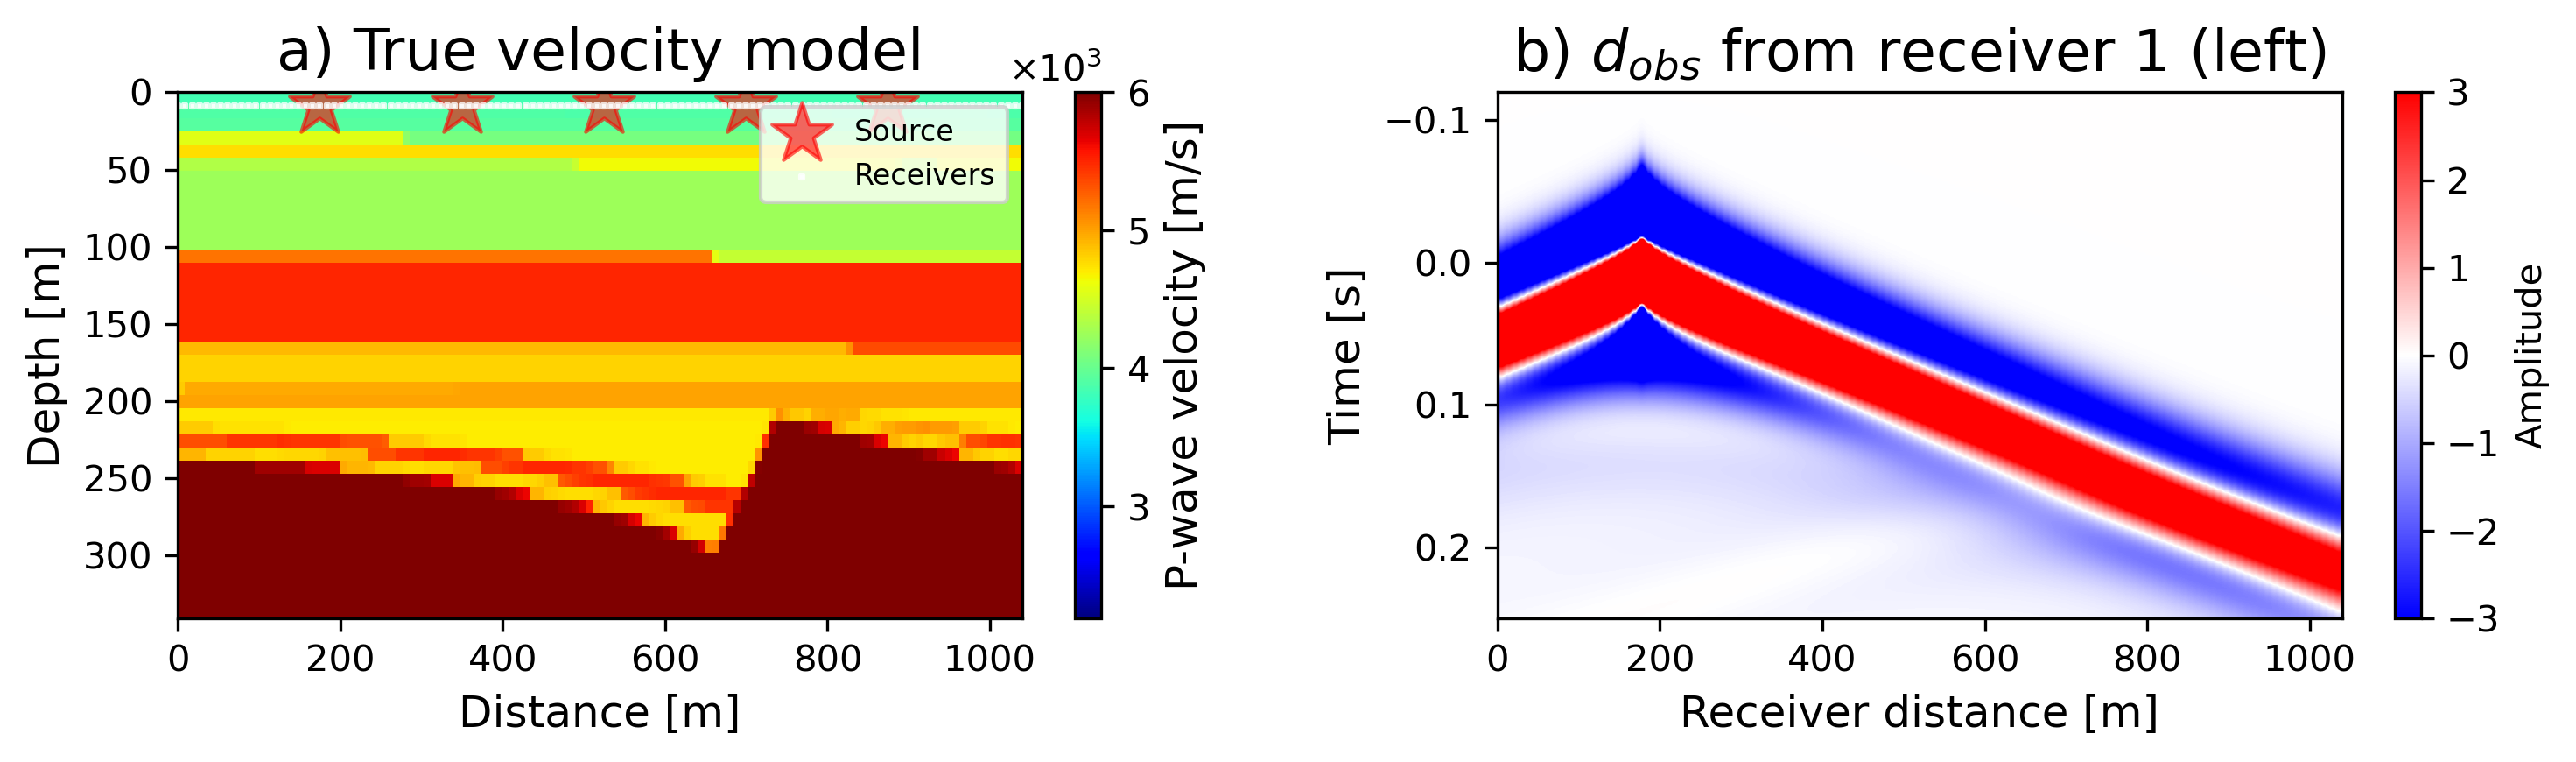

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from IPython.display import clear_output
import numpy as np
import cupy as cp
import cupyx
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import time
labelsize = 16

from func.propagation_matrix import defmodel, extend_model
from func.velocity_model import gaussian2d
from joblib import Parallel, delayed

precision = np.float64
device = 'cpu'


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))
    zxrec = zxrec1

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec, indices = np.unique(zxrec,return_index=True,axis=1)

  return zxrec[:, np.argsort(indices)]

def extend_model(v,nz,nx,next):
	"""
	Extension of the model (to limit the edge effects)
	"""
	vel = v.reshape((nz,nx))
	nze  = nz + 2*next
	nxe  = nx + 2*next
	vele = np.zeros([nze,nxe], dtype=precision)
	# Central part
	vele[next:nze-next,next:nxe-next] = vel
	# Top and bottomB
	for ix in range(next,nxe-next):
		for iz in range(next):
			vele[iz,ix]       = vel[0,ix-next]
			vele[nze-1-iz,ix] = vel[nz-1,ix-next]
	# Left and right
	for ix in range(next):
		for iz in range(next,nze-next):
			vele[iz,ix]       = vel[iz-next,0]
			vele[iz,nxe-1-ix] = vel[iz-next,nx-1]
	# Corners
	for ix in range(next):
		for iz in range(next):
			vele[iz,ix]             = vel[0,0]
			vele[nze-1-iz,ix]       = vel[nz-1,0]
			vele[iz,nxe-1-ix]       = vel[0,nx-1]
			vele[nze-1-iz,nxe-1-ix] = vel[nz-1,nx-1]
	return vele.flatten()

def prop2d(wsrc, zxsrci, zxrec, vel, at, az, ax, next, device='cpu'):
	"""
	2d wave propagation with multiple sources
	"""
	
	if device=='cpu':
		"""
		2d wave propagation
		Resolution with finite differences
		Orders 2 in time and space
		with absorbing boundaries (Clayton and Engquist)
		Vectorial implementation (much faster)
		"""
		nabs  = 10
		next2 = nabs + next
		nt    = len(at)
		nz    = len(az)
		nx    = len(ax)
		dz    = az[1] - az[0]
		dx    = ax[1] - ax[0]
		dt    = at[1] - at[0]   
		_dz2   = 1./dz**2
		_dx2   = 1./dx**2

		nze = nz + 2 * next2
		nxe = nx + 2 * next2
		size = nze * nxe

		# Calculate source waveform
		wsrc = np.array([wsrc]) if wsrc.ndim == 1 else np.array(wsrc) # convert source wavelet from 1d to 2d
		zxsrci = np.array(zxsrci) # source location to array

		# Extend the model
		nze  = nz + 2*next2
		nxe  = nx + 2*next2
		vele = extend_model(vel,nz,nx,next2)
		vele = vele.flatten()

		# Center Part (Laplacian)
		mask0 = np.full((nze, nxe), False)
		mask0[1+nabs:-1-nabs,1+nabs:-1-nabs] = True
		mask0 = mask0.flatten()

		# Construct the Laplacian matrix
		fact = (dt * vele)**2

		# Initialize arrays
		diagonal = np.zeros(size)
		off_diagonal_x_left = np.zeros(size)
		off_diagonal_x_right = np.zeros(size)
		off_diagonal_z_left = np.zeros(size)
		off_diagonal_z_right = np.zeros(size)

		# Set values for interior points
		diagonal[mask0] = (2*np.ones(size) + fact*(-2*np.ones(size)*(_dz2+_dx2)))[mask0]
		off_diagonal_x_left[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_x_right[mask0] = (fact*np.ones(size) * _dz2)[mask0]
		off_diagonal_z_left[mask0] = (fact*np.ones(size) * _dx2)[mask0]
		off_diagonal_z_right[mask0] = (fact*np.ones(size) * _dx2)[mask0]

		# Calculate factors for boundary conditions
		factz = (-dt/dz) * vele
		factx = (-dt/dx) * vele

		# Bottom part
		mask1 = np.full((nze, nxe), False)
		mask1[nze-1-nabs:nze,:nxe] = True
		mask1 = mask1.flatten()
		diagonal[mask1] = 1 + factz[mask1]
		off_diagonal_z_left[mask1] = -factz[mask1]

		# Top part
		mask2 = np.full((nze, nxe), False)
		mask2[:1+nabs,:nxe] = True
		mask2 = mask2.flatten()
		diagonal[mask2] = 1 + factz[mask2]
		off_diagonal_z_right[mask2] = -factz[mask2]

		# Right part
		mask3 = np.full((nze, nxe), False)
		mask3[:nze,nxe-1-nabs:nxe] = True
		mask3 = mask3.flatten()
		diagonal[mask3] = 1 + factx[mask3]
		off_diagonal_x_left[mask3] = -factx[mask3]

		# Left part
		mask4 = np.full((nze, nxe), False)
		mask4[:nze,:1+nabs]  = True
		mask4 = mask4.flatten()
		diagonal[mask4] = 1 + factx[mask4]
		off_diagonal_x_right[mask4] = -factx[mask4]

		# Construct the sparse Laplacian matrix
		A = sp.diags([off_diagonal_x_left[1:], off_diagonal_z_left[nxe:], diagonal, off_diagonal_z_right, off_diagonal_x_right],
								[-1, -nxe, 0, nxe, 1], shape=(size, size), format='csr')

		# Wavefield p mask (initial center part)
		maskp = np.full((nze, nxe), 0)
		maskp[next+nabs:nze-next-nabs,next+nabs:nxe-next-nabs]  = 1
		maskp = maskp.flatten()

		pm = np.zeros(size) # Previous wave field
		pt = np.zeros(size)
		pp = np.zeros(size)

		p = [np.zeros(nz*nx)]
		p.append(np.zeros(nz*nx))

		srcsteps = wsrc.shape[1] # Determine the time steps of the source
		for it in range(1,nt-1): # From 1 to nt-1
			pm = pt.copy()
			pt = pp.copy()
			# pp = A.dot(pt) - pm*mask0 + pwsrc[:,it]*fact*mask0
			if it<srcsteps:
				cen = np.zeros((nz,nx))
				cen[zxsrci[0,:], zxsrci[1,:]] = wsrc[:,it]
				asrcit = np.pad(cen, next2, mode='constant').flatten()
				srcterm = asrcit*fact*mask0
			else: srcterm = np.zeros(size)

			pp = A.dot(pt) - pm*mask0 + srcterm
			p.append(pp[maskp==1])

		p = np.moveaxis(np.array(p), 0, -1)
		d_obs = p.reshape((nz,nx,nt))[zxrec[0], zxrec[1], :]

	return p, d_obs

def second_order_derivative_cpu(p, at, az, ax):
	"""
	Calculate second order derivative for p(z,x,t)
	method: finite-difference
	"""
	# extend model to tmin=0 tmax=0 -- insert zeros in dimension t
	nz, nx = len(az), len(ax)
	dt = at[1] - at[0]
	# Modify p array in-place without copying
	p[:, 0] = 0.0
	p[:, -1] = 0.0
	_dt2 = 1./dt**2
	# Calculate second order derivative using vectorized operations
	p_dt_dt = (p[:, :-2] - 2 * p[:, 1:-1] + p[:, 2:]) * _dt2
	# Insert zeros at boundaries using array views
	p_dt_dt = np.concatenate([np.zeros((nz*nx, 1)), p_dt_dt, np.zeros((nz*nx, 1))], axis=1)

	return p_dt_dt

def readbin(flnam,nz,nx):
    # Read binary file (32 bits)
    with open(flnam,"rb") as fl:
        im = np.fromfile(fl, dtype=np.float32)
    im = im.reshape(nz,nx,order='F')
    return im

def disp_fwd(vel, d_obs):
	plt.figure(figsize=(10,3), dpi=300)
	plt.subplot(1,2,1) 
	plt.imshow(vel.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("a) True velocity model",fontsize=labelsize)

	plt.subplot(1,2,2)
	plt.imshow(tf.transpose(d_obs[0]),cmap='bwr',vmin=-3,vmax=3,extent=[ax[0], ax[-1],at[-1], at[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.set_label("Amplitude")
	plt.title("b) $d_{obs}$ from receiver 1 (left)", fontsize=labelsize)
	plt.xlabel('Receiver distance [m]', fontsize=labelsize-4)
	plt.ylabel('Time [s]', fontsize=labelsize-4)
	plt.tight_layout()
	plt.show()


# Initialize the model axis az, ax, at
nz,nx,nt = 40,120,400
# vmin,vmax = 1000,4500
izsrc, ixsrc = [1], [nx//2]
next = 100

## Choose a true velocity field
## Read the original input data
# vel   = readbin('../dataset/marm2_sel.dat',nz,nx)[1:,1:]
# vel = vel[::5,::5]
# v_ref = vel * 1e3

## Choose reference velocity field from dataset
# v_ref = cropped_images[1000,:,:,0].numpy()

# # Generate a velocity field
# z = tf.random.normal([1, dim_z])
# m = G_func(z).numpy()
# v_ref = tf.reshape(m,[nz,nx]).numpy()
v_ref = cropped_images[860,:,:,0].numpy()

print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

# vmin,vmax = v_ref.min(),v_ref.max()

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.arange(0,nx)
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

zxsrc = np.array([[1,1,1,1,1], [nx//6,2*nx//6,3*nx//6,4*nx//6,5*nx//6]])
# zxsrc = np.array([[1], [3*nx//6]])
nsrc = zxsrc.shape[1]
d_obs = []
for i in range(nsrc):
  zxsrci = tf.expand_dims(zxsrc[:,i],-1)
  p, d_obs_i = prop2d(wsrc, zxsrci, zxrec, v_ref, at, az, ax, next)
  d_obs.append(d_obs_i)

disp_fwd(v_ref, d_obs)

### Inversion

In [ ]:
# Modified FWI objective function with regularization
def J_z(z,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise):
	# Map from z to m
	z_tf = tf.expand_dims(z,0)
	m = G_func(z_tf)
	vel = m.numpy()
	nsrc = zxsrc.shape[1]
	Js = 0
	for i in range(nsrc):
			zxsrci = np.expand_dims(zxsrc[:,i],-1)
			nz, nx = len(az), len(ax)
			if vel.ndim == 1: vel = np.reshape(vel.flatten(),(nz,nx))
			_, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
			residual = d - d_obs[i]
			J = 0.5 * np.sum(residual ** 2) # Residual is the half of the L2 norm square
			Js += J
	print("Loss (J) = %.4f " % Js, end='')
	
	mu = 0
	Q = sc.sparse.identity(dim_z)
	penalty = 0.5 * (z-mu).T.dot(Q.dot(z-mu)) * std_noise**2
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = Js + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,Js,penalty])

	return loss

# Modified FWI gradient with regularization
def gradient_z(z,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise):
	# Map from z to m
	z_tf = tf.expand_dims(z,0)
	with tf.GradientTape() as tape:
		tape.watch(z_tf)
		m = G_func(z_tf)
	dm_dz = tape.jacobian(m,z_tf)
	dm_dz = tf.reshape(dm_dz,[40*120,noise_dim]).numpy()
	vel = m.numpy()

	nsrc = zxsrc.shape[1]
	grads = np.zeros_like(vel)
	for i in range(nsrc):
		print('Source', i, end='...   ')
		zxsrci = np.expand_dims(zxsrc[:,i],-1)
		p_fwd, d = prop2d(wsrc,zxsrci,zxrec,vel,at,az,ax,next,device)
		residual = d - d_obs[i] # residual shape (n_rec, nt) - residual.shape=(5,801)
		# Calculate back propagated p_back(z,x,t)
		p_back, _ = prop2d(np.flip(residual,axis=1), zxrec, zxsrc, vel, at, az, ax, next, device)
		p_back = np.flip(p_back,axis=1)
		# Calculate second order time derivative of p_fwd(z,x,t)
		p_dt_dt = second_order_derivative_cpu(p_fwd, at, az, ax)
		# Calculate gradiant
		grad = 2/vel**3  * np.sum(p_back * p_dt_dt, axis=1) # G.shape same as vel
		grads += grad

	mu = 0 # Latent Gaussian's mean
	Q = sc.sparse.identity(dim_z)	# Latent Gaussian's variance^-1
	grad_J = np.expand_dims(grads,0)
	grad_penalty = Q.dot(z-mu) * std_noise**2
	total_grad = grad_J @ dm_dz + grad_penalty

	return total_grad.flatten()


At iterate   40    f=  1.48478D+03    |proj g|=  3.98602D+00


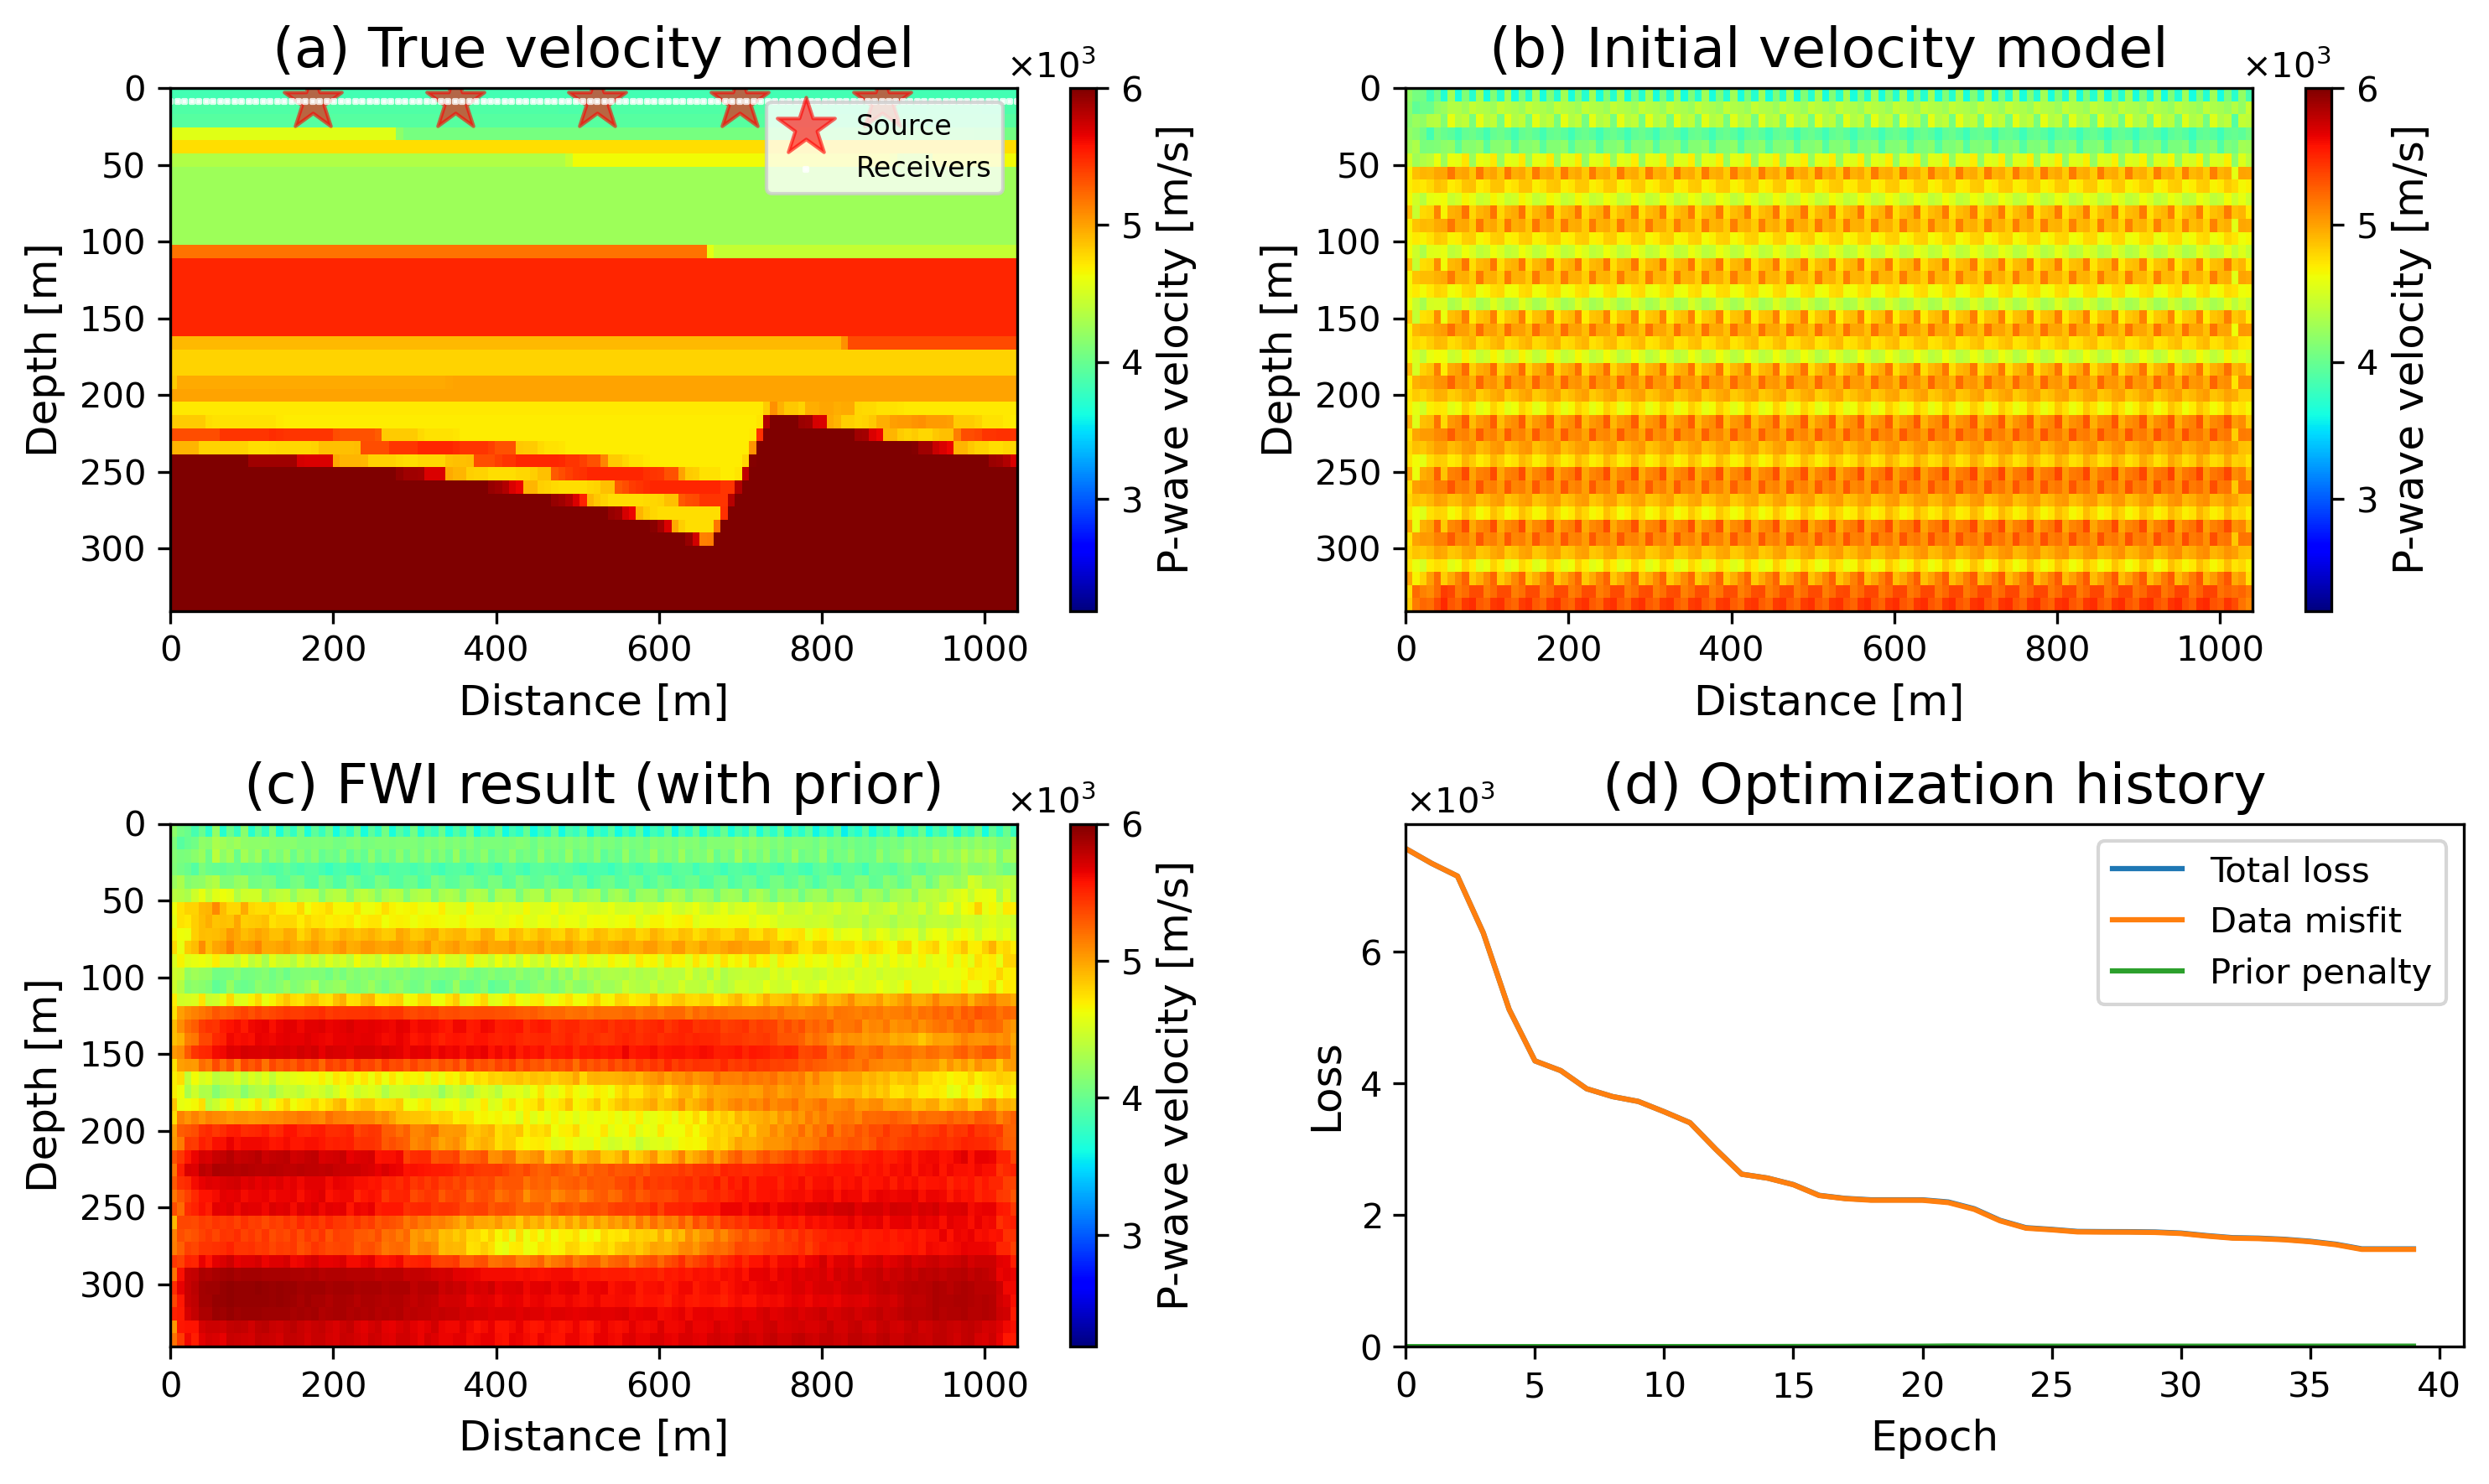

Loss (J) = 1521.5657 Penalty term = 7.1658 Total loss = 1528.7315 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1478.7556 Penalty term = 7.1472 Total loss = 1485.9028 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.7525 Penalty term = 7.1455 Total loss = 1484.8980 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6485 Penalty term = 7.1452 Total loss = 1484.7937 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6337 Penalty term = 7.1452 Total loss = 1484.7788 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6314 Penalty term = 7.1452 Total loss = 1484.7766 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6309 Penalty term = 7.1452 Total loss = 1484.7760 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6308 Penalty term = 7.145


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


Loss (J) = 1088225.1732 Penalty term = 445.7663 Total loss = 1088670.9395 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 86241.2604 Penalty term = 7.1703 Total loss = 86248.4307 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1482.0550 Penalty term = 7.1448 Total loss = 1489.1998 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.9424 Penalty term = 7.1451 Total loss = 1485.0875 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6731 Penalty term = 7.1451 Total loss = 1484.8182 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6371 Penalty term = 7.1452 Total loss = 1484.7822 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6323 Penalty term = 7.1452 Total loss = 1484.7774 
Source 0...   Source 1...   Source 2...   Source 3...   Source 4...   Loss (J) = 1477.6312 Penalty te


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ValueError: cannot reshape array of size 100 into shape (40,120)

In [ ]:
# Record loss history over each iterations
def callback(x):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	clear_output(wait=True)

	plt.figure(figsize=(10,6), dpi=300)
	# Plot the true velocity
	plt.subplot(221)
	plt.imshow(v_ref.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.scatter(dz*zxsrc[1,:],dx*zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
	plt.scatter(dz*zxrec[1,:],dx*zxrec[0,:],marker='s',color='w',s=1,alpha=0.8,label="Receivers")
	plt.legend(loc='upper right',fontsize=labelsize-8)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(a) True velocity model",fontsize=labelsize)

	# Plot the initial velocity
	plt.subplot(222)
	plt.imshow(v_init.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(b) Initial velocity model",fontsize=labelsize)

	# Display current velocity field
	plt.subplot(223)
	v_fwi = G_func(tf.expand_dims(x,0)).numpy()
	plt.imshow(v_fwi.reshape((nz,nx)),vmin=vmin,vmax=vmax,cmap='jet',extent=[ax[0],ax[-1],az[-1],az[0]], aspect='auto')
	cbar = plt.colorbar()
	cbar.formatter.set_useMathText(True)
	cbar.formatter.set_scientific(True)
	cbar.formatter.set_powerlimits((-1, 1))  # Adjust these limits as needed
	cbar.update_ticks()
	cbar.set_label("P-wave velocity [m/s]", fontsize=labelsize-4)
	plt.xlabel('Distance [m]', fontsize=labelsize-4)
	plt.ylabel('Depth [m]', fontsize=labelsize-4)
	plt.title("(c) FWI result (with prior)",fontsize=labelsize)

	# Display loss track
	plt.subplot(224)
	plt.plot(loss_tracker,lw=1.5)
	plt.legend(['Total loss','Data misfit','Prior penalty'])
	# Set the x-axis tick formatter to scientific notation
	formatter = ScalarFormatter(useMathText=True)
	formatter.set_scientific(True)
	formatter.set_powerlimits((-2,2))  # Adjust these limits as needed
	plt.gca().yaxis.set_major_formatter(formatter)
	plt.legend(['Total loss','Data misfit','Prior penalty'])
	plt.xlim(xmin=0)
	plt.ylim(ymin=0)
	plt.xlabel('Epoch', fontsize=labelsize-4)
	plt.ylabel('Loss', fontsize=labelsize-4)
	plt.title("(d) Optimization history",fontsize=labelsize)

	plt.tight_layout()
	plt.show()

from scipy.optimize import minimize
# minimize cost function
z0 = np.zeros(dim_z)
v_init = G_func(tf.expand_dims(z0,0)).numpy()

loss_tracker = np.empty((0,3))

std_noise = 1 # define the noise level

resi = minimize(fun = J_z, 
               x0 = z0, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise),
               method='L-BFGS-B', 
               # method='Newton-CG',
               bounds = np.full((len(z0.flatten()), 2), (-3,3)),
               jac = gradient_z,
               options = {'disp':True, 'maxiter':500},
               callback=callback
              )
v_fwi = resi.x

In [ ]:
v_fwi.shape

(100,)